# Visualizing model bias

**Created on November 2, 2016**

Under a forward model for a galaxy image, the model ellipticity is exactly degenerate with reduced shear assuming:

1. weak shear approximation
2. the model is a *perfect description of the data*

where, by *perfect description of the data* we mean that the residual of data minus model is indistinguishable from the pixel noise using any arbitrary statistical summary of the image.

With the above assumptions, we can consider a plot of intrinsic model ellipticity (i.e., pre-shear) versus reduced shear. The degeneracy of these parameters should yield lines of constant *observed* ellipticity with a slope of $-1$. Finally, when there is model fitting bias we should expect to see a deviation from this straight line as a function applied shear in the image - giving us a new way to visualize and think about the way model bias can bias the shear inferences when forward modeling galaxy images.

In [47]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import galsim
import jif

plt.style.use('ggplot')

In [126]:
def sim_galaxy_image(galaxy_model_gg="Spergel", 
                     active_parameters_gg=['e'], 
                     params_noshear_gg=[0.3],
                     ngrid=256, seed=590025467011):
    """
    Simulate a galaxy image with the specified model and parameters
    
    @returns GalSim images for the galaxy and PSF
    """
    gg = jif.GalSimGalaxyModel(galaxy_model=galaxy_model_gg, 
            telescope_model="LSST",
            psf_model="Model",
            active_parameters=active_parameters_gg)
    gg.set_params(params_noshear_gg)

    out_image = galsim.Image(ngrid, ngrid, init_value=0.)
    im = gg.get_image(out_image=out_image)

    noise = jif.telescopes.lsst_noise(random_seed=seed)
    im.addNoise(noise)

    psf_im = gg.get_psf_image(ngrid=ngrid)
    return im, psf_im

def apply_shear(e, g):
    return (e + g) #/ (1.0 + g.conjugate() * e)

def unshear(e, g):
    return (e - g) #/ (1.0 - g.conjugate() * e)

def shear_params(p, g):
    e1 = p[0] * np.cos(2*p[1])
    e2 = p[0] * np.sin(2*p[1])

    e_int_c = complex(e1, e2)
    g_c = complex(g[0], g[1])
    e_sh = apply_shear(e_int_c, g_c)

    e = np.abs(e_sh)
    beta = np.mod(np.arctan2(e_sh.imag, e_sh.real) / 2., np.pi)
    return [e, beta]

def get_eobs_from_applied_shear(g1):
    """
    Simulate an image with the given shear and get the observed ellipticity estimator
    """
    e_int_bulge = 0.0
    beta_int_bulge = 0.2
    e_obs_disk = 0.3
    beta_obs_disk = 0.0
    
    e_obs_bulge, beta_obs_bulge = shear_params([e_int_bulge, beta_int_bulge], [g1, 0.0])
    
    paramnames = ['e_bulge', 'beta_bulge', 'hlr_disk', 'e_disk', 'beta_disk', 'mag_sed1_disk']
    params = [e_obs_bulge, beta_obs_bulge, 1.6,  e_obs_disk, beta_obs_disk, 27.0]
    
    im, psf_im = sim_galaxy_image(galaxy_model_gg="BulgeDisk",
                                  active_parameters_gg=paramnames,
                                  params_noshear_gg=params)
    hsm_out = galsim.hsm.EstimateShear(im, psf_im)
    return hsm_out.observed_shape.getG1()

galsim.Shear(g1=0.0806180843372,g2=0.00232257864927)


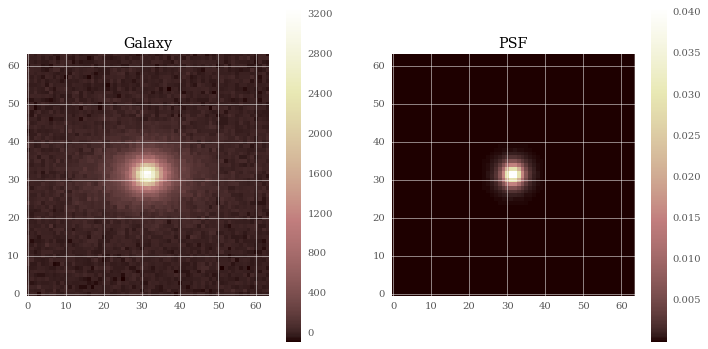

In [127]:
galaxy_model_gg = "BulgeDisk"
active_parameters_gg = ['e_bulge', 'beta_bulge', 'hlr_disk', 'e_disk', 'beta_disk', 'mag_sed1_disk']
params_noshear_gg = [0.0, 0.2, 1.6, 0.3, 0.0, 27.]

# galaxy_model_gg = "Spergel"
# active_parameters_gg = ['nu', 'hlr', 'e', 'beta', 'mag_sed1']
# params_noshear_gg = [0.3, 10.0, 0.3, 0.0, 22.5]

im, psf_im = sim_galaxy_image(galaxy_model_gg, active_parameters_gg, 
                              params_noshear_gg, ngrid=64)

fig = plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(im.array, interpolation='none', origin='lower', cmap=plt.cm.pink)
plt.title("Galaxy")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(psf_im.array, interpolation='none', origin='lower', cmap=plt.cm.pink)
plt.title("PSF")
plt.colorbar()

hsm_out = galsim.hsm.EstimateShear(im, psf_im)
# print hsm_out.observed_shape.getG1()
print hsm_out.observed_shape

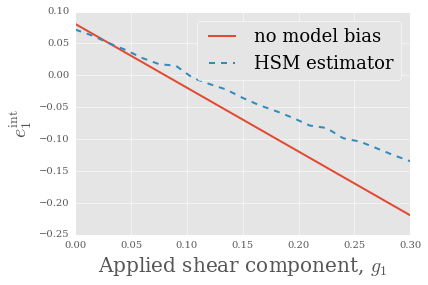

In [131]:
g = np.linspace(0., 0.3, 21)
e_obs = np.array([get_eobs_from_applied_shear(g1) for g1 in g])

plt.plot([0, 0.3], [0.0806, 0.0806 - 0.3], '-', label='no model bias')
plt.plot(g, e_obs - g, '--', label='HSM estimator')
plt.xlabel(r"Applied shear component, $g_1$", fontsize=20)
plt.ylabel(r"$e^{\rm int}_1$", fontsize=20)
plt.legend(fontsize=18)